In [1]:
# --- CELL 1: Imports & Global Configuration ---------------------------------
from __future__ import annotations

# Core
import os
from pathlib import Path
import sys
from typing import Optional, List, Dict, Any

# Data
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Utils
import logging
import textwrap

# Matplotlib settings (clean defaults)
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

# Logging (concise info-level logs)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)-8s | %(message)s",
    datefmt="%H:%M:%S",
)
logger = logging.getLogger(__name__)

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)


In [2]:
# --- CELL 2: Project Paths ---------------------------------------------------
def get_project_root(start: Optional[Path] = None) -> Path:
    """
    Returns the project root directory.
    Logic: if running inside notebooks/, go one level up; else use CWD.
    """
    p = Path.cwd() if start is None else start
    return p.parent if p.name.lower() == "notebooks" else p

ROOT = get_project_root()
DATA_DIR = ROOT / "data"
REPORTS_DIR = ROOT / "reports"
FIGS_DIR = ROOT / "figures"

# Input CSV (uploaded path reference)
CISA_KEV_CSV = DATA_DIR / "cisa_kev.csv"   # make sure the file exists here

# Ensure output dirs exist
for d in [REPORTS_DIR, FIGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

logger.info("ROOT       : %s", ROOT)
logger.info("DATA_DIR   : %s", DATA_DIR)
logger.info("REPORTS_DIR: %s", REPORTS_DIR)
logger.info("FIGS_DIR   : %s", FIGS_DIR)
logger.info("CSV exists?: %s", CISA_KEV_CSV.exists())


22:36:17 | INFO     | ROOT       : C:\global_cyberattack_dm
22:36:17 | INFO     | DATA_DIR   : C:\global_cyberattack_dm\data
22:36:17 | INFO     | REPORTS_DIR: C:\global_cyberattack_dm\reports
22:36:17 | INFO     | FIGS_DIR   : C:\global_cyberattack_dm\figures
22:36:17 | INFO     | CSV exists?: True


In [3]:
# --- CELL 3: Small Utilities -------------------------------------------------
def safe_parse_datetime(series: pd.Series, errors: str = "coerce") -> pd.Series:
    """Safely parse datetime strings; returns NaT on failures."""
    return pd.to_datetime(series, errors=errors, utc=True).dt.tz_localize(None)

def normalize_whitespace(s: pd.Series) -> pd.Series:
    """Strip, collapse multiple spaces, and standardize whitespace."""
    return (
        s.astype(str)
         .str.replace(r"\s+", " ", regex=True)
         .str.strip()
         .replace({"nan": np.nan})
    )

def optional_cols(df: pd.DataFrame, cols: List[str]) -> List[str]:
    """Return subset of columns that actually exist in df."""
    return [c for c in cols if c in df.columns]


In [6]:
# --- CELL 4: Load Data & Basic Integrity ------------------------------------
assert CISA_KEV_CSV.exists(), f"CSV not found at {CISA_KEV_CSV}"

df_raw = pd.read_csv(CISA_KEV_CSV)
logger.info("Loaded CSV with shape: %s", df_raw.shape)

# Quick peek (sample to avoid huge prints)
display(df_raw.head(10))

# Basic info
logger.info("Columns: %s", list(df_raw.columns))
logger.info("Null counts:\n%s", df_raw.isna().sum())


22:42:37 | INFO     | Loaded CSV with shape: (1442, 11)


,cveID,vendorProject,product,vulnerabilityName,dateAdded,shortDescription,requiredAction,dueDate,knownRansomwareCampaignUse,notes,cwes
0,CVE-2025-54253,Adobe,Experience Manager (AEM) Forms,Adobe Experience Manager Forms Code Execution Vulnerability,2025-10-15,Adobe Experience Manager Forms in JEE contains an unspecified vulnerability that allows for arbitrary code execution.,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",2025-11-05,Unknown,https://helpx.adobe.com/security/products/aem-forms/apsb25-82.html ; https://nvd.nist.gov/vuln/detail/CVE-2025-54253,NaN
1,CVE-2025-47827,IGEL,IGEL OS,IGEL OS Use of a Key Past its Expiration Date Vulnerability,2025-10-14,"IGEL OS contains a use of a key past its expiration date vulnerability that allows for Secure Boot bypass. The igel-flash-driver module improperly verifies a cryptographic signature. Ultimately, a...","Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",2025-11-04,Unknown,https://msrc.microsoft.com/update-guide/en-US/vulnerability/CVE-2025-47827 ; https://nvd.nist.gov/vuln/detail/CVE-2025-47827,CWE-324
2,CVE-2025-24990,Microsoft,Windows,Microsoft Windows Untrusted Pointer Dereference Vulnerability,2025-10-14,Microsoft Windows Agere Modem Driver contains an untrusted pointer dereference vulnerability that allows for privilege escalation. An attacker who successfully exploited this vulnerability could g...,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",2025-11-04,Unknown,https://msrc.microsoft.com/update-guide/en-US/vulnerability/CVE-2025-24990 ; https://nvd.nist.gov/vuln/detail/CVE-2025-24990,CWE-822
3,CVE-2025-59230,Microsoft,Windows,Microsoft Windows Improper Access Control Vulnerability,2025-10-14,Microsoft Windows contains an improper access control vulnerability in Windows Remote Access Connection Manager which could allow an authorized attacker to elevate privileges locally.,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",2025-11-04,Unknown,https://msrc.microsoft.com/update-guide/en-US/vulnerability/CVE-2025-59230 ; https://nvd.nist.gov/vuln/detail/CVE-2025-59230,CWE-284
4,CVE-2025-6264,Rapid7,Velociraptor,Rapid7 Velociraptor Incorrect Default Permissions Vulnerability,2025-10-14,Rapid7 Velociraptor contains an incorrect default permissions vulnerability that can lead to arbitrary command execution and endpoint takeover. To successfully exploit this vulnerability the user ...,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",2025-11-04,Known,https://docs.velociraptor.app/announcements/advisories/cve-2025-6264/ ; https://nvd.nist.gov/vuln/detail/CVE-2025-6264,CWE-276
5,CVE-2016-7836,SKYSEA,Client View,SKYSEA Client View Improper Authentication Vulnerability,2025-10-14,SKYSEA Client View contains an improper authentication vulnerability that allows remote code execution via a flaw in processing authentication on the TCP connection with the management console pro...,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",2025-11-04,Unknown,https://www.skyseaclientview.net/news/161221/ ; https://nvd.nist.gov/vuln/detail/CVE-2016-7836,CWE-287
6,CVE-2021-43798,Grafana Labs,Grafana,Grafana Path Traversal Vulnerability,2025-10-09,Grafana contains a path traversal vulnerability that could allow access to local files.,"Apply mitigations per vendor instructions, follow applicable BOD 2

22:42:37 | INFO     | Columns: ['cveID', 'vendorProject', 'product', 'vulnerabilityName', 'dateAdded', 'shortDescription', 'requiredAction', 'dueDate', 'knownRansomwareCampaignUse', 'notes', 'cwes']
22:42:37 | INFO     | Null counts:
cveID                           0
vendorProject                   0
product                         0
vulnerabilityName               0
dateAdded                       0
shortDescription                0
requiredAction                  0
dueDate                         0
knownRansomwareCampaignUse      0
notes                           0
cwes                          161
dtype: int64


In [9]:
# load data & Basic Integrity ------------------------------------
# Verify the dataset exists
assert CISA_KEV_CSV.exists(), f"❌ CSV file not found at: {CISA_KEV_CSV}"

# Load the CSV file into a DataFrame
df_raw = pd.read_csv(CISA_KEV_CSV)

# Log dataset shape
logger.info("✅ Loaded CSV successfully | Shape: %s", df_raw.shape)

# Display a small preview for inspection
display(df_raw.head(10))

# --- Summary Statistics -----------------------------------------------------
logger.info("📋 Columns: %s", list(df_raw.columns))

# Print data types in a nice table
print("\n🧠 COLUMN DATA TYPES:")
print(df_raw.dtypes)

# Count missing values per column
null_summary = df_raw.isna().sum()
print("\n🚫 NULL VALUE COUNTS:")
print(null_summary[null_summary > 0] if null_summary.sum() else "No missing values detected.")

# Show number of unique values (helps spot categorical vs numeric)
unique_summary = df_raw.nunique().sort_values(ascending=False)
print("\n🔢 UNIQUE VALUES PER COLUMN:")
print(unique_summary)

# Optional: concise overall info summary
print("\n📈 DataFrame Info Summary:")
df_raw.info()

logger.info("Data integrity check complete.")


22:49:17 | INFO     | ✅ Loaded CSV successfully | Shape: (1442, 11)


,cveID,vendorProject,product,vulnerabilityName,dateAdded,shortDescription,requiredAction,dueDate,knownRansomwareCampaignUse,notes,cwes
0,CVE-2025-54253,Adobe,Experience Manager (AEM) Forms,Adobe Experience Manager Forms Code Execution Vulnerability,2025-10-15,Adobe Experience Manager Forms in JEE contains an unspecified vulnerability that allows for arbitrary code execution.,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",2025-11-05,Unknown,https://helpx.adobe.com/security/products/aem-forms/apsb25-82.html ; https://nvd.nist.gov/vuln/detail/CVE-2025-54253,NaN
1,CVE-2025-47827,IGEL,IGEL OS,IGEL OS Use of a Key Past its Expiration Date Vulnerability,2025-10-14,"IGEL OS contains a use of a key past its expiration date vulnerability that allows for Secure Boot bypass. The igel-flash-driver module improperly verifies a cryptographic signature. Ultimately, a...","Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",2025-11-04,Unknown,https://msrc.microsoft.com/update-guide/en-US/vulnerability/CVE-2025-47827 ; https://nvd.nist.gov/vuln/detail/CVE-2025-47827,CWE-324
2,CVE-2025-24990,Microsoft,Windows,Microsoft Windows Untrusted Pointer Dereference Vulnerability,2025-10-14,Microsoft Windows Agere Modem Driver contains an untrusted pointer dereference vulnerability that allows for privilege escalation. An attacker who successfully exploited this vulnerability could g...,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",2025-11-04,Unknown,https://msrc.microsoft.com/update-guide/en-US/vulnerability/CVE-2025-24990 ; https://nvd.nist.gov/vuln/detail/CVE-2025-24990,CWE-822
3,CVE-2025-59230,Microsoft,Windows,Microsoft Windows Improper Access Control Vulnerability,2025-10-14,Microsoft Windows contains an improper access control vulnerability in Windows Remote Access Connection Manager which could allow an authorized attacker to elevate privileges locally.,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",2025-11-04,Unknown,https://msrc.microsoft.com/update-guide/en-US/vulnerability/CVE-2025-59230 ; https://nvd.nist.gov/vuln/detail/CVE-2025-59230,CWE-284
4,CVE-2025-6264,Rapid7,Velociraptor,Rapid7 Velociraptor Incorrect Default Permissions Vulnerability,2025-10-14,Rapid7 Velociraptor contains an incorrect default permissions vulnerability that can lead to arbitrary command execution and endpoint takeover. To successfully exploit this vulnerability the user ...,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",2025-11-04,Known,https://docs.velociraptor.app/announcements/advisories/cve-2025-6264/ ; https://nvd.nist.gov/vuln/detail/CVE-2025-6264,CWE-276
5,CVE-2016-7836,SKYSEA,Client View,SKYSEA Client View Improper Authentication Vulnerability,2025-10-14,SKYSEA Client View contains an improper authentication vulnerability that allows remote code execution via a flaw in processing authentication on the TCP connection with the management console pro...,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",2025-11-04,Unknown,https://www.skyseaclientview.net/news/161221/ ; https://nvd.nist.gov/vuln/detail/CVE-2016-7836,CWE-287
6,CVE-2021-43798,Grafana Labs,Grafana,Grafana Path Traversal Vulnerability,2025-10-09,Grafana contains a path traversal vulnerability that could allow access to local files.,"Apply mitigations per vendor instructions, follow applicable BOD 2

22:49:17 | INFO     | 📋 Columns: ['cveID', 'vendorProject', 'product', 'vulnerabilityName', 'dateAdded', 'shortDescription', 'requiredAction', 'dueDate', 'knownRansomwareCampaignUse', 'notes', 'cwes']
22:49:17 | INFO     | Data integrity check complete.



🧠 COLUMN DATA TYPES:
cveID                         object
vendorProject                 object
product                       object
vulnerabilityName             object
dateAdded                     object
shortDescription              object
requiredAction                object
dueDate                       object
knownRansomwareCampaignUse    object
notes                         object
cwes                          object
dtype: object

🚫 NULL VALUE COUNTS:
cwes    161
dtype: int64

🔢 UNIQUE VALUES PER COLUMN:
cveID                         1442
notes                         1442
shortDescription              1358
vulnerabilityName             1134
product                        587
dueDate                        360
dateAdded                      340
vendorProject                  238
cwes                           211
requiredAction                  40
knownRansomwareCampaignUse       2
dtype: int64

📈 DataFrame Info Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 e

In [10]:
# --- CELL 5: Standardize Columns & Types ------------------------------------
df = df_raw.copy()

# 1) Normalize whitespace for key text columns
text_cols = [
    "cveID", "vendorProject", "product", "vulnerabilityName",
    "shortDescription", "requiredAction", "notes", "cwes",
    "knownRansomwareCampaignUse"
]
for col in [c for c in text_cols if c in df.columns]:
    df[col] = (
        df[col].astype(str)
               .str.replace(r"\s+", " ", regex=True)
               .str.strip()
               .replace({"nan": pd.NA})
    )

# 2) Parse dates safely
for col in ["dateAdded", "dueDate"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", utc=True).dt.tz_localize(None)

# 3) Derive CVE year from cveID (e.g., "CVE-2021-12345" -> 2021)
if "cveID" in df.columns:
    df["cveYear"] = (
        df["cveID"]
        .str.extract(r"CVE-(\d{4})", expand=False)
        .astype("Int64")
    )

# 4) Normalize ransomware usage to boolean (Yes/No/Known/Unknown)
if "knownRansomwareCampaignUse" in df.columns:
    map_yes = {"yes", "true", "y", "1", "known"}
    map_no  = {"no", "false", "n", "0", "unknown"}
    def _to_bool(x: str):
        if x is pd.NA or x is None: 
            return pd.NA
        s = str(x).strip().lower()
        if s in map_yes: return True
        if s in map_no:  return False
        return pd.NA
    df["knownRansomwareCampaignUse"] = df["knownRansomwareCampaignUse"].map(_to_bool).astype("boolean")

# 5) Clean CWE list into a normalized column (list of codes) without spaces
if "cwes" in df.columns:
    df["cwes"] = (
        df["cwes"]
          .dropna()
          .astype(str)
          .str.split(r"[,\s]+")
          .map(lambda lst: [c.strip() for c in lst if c.strip()])  # remove empties
    ).reindex(df.index)  # keep original index alignment

# 6) Reorder columns (nice reading order)
preferred_order = [
    "cveID", "cveYear", "vendorProject", "product", "vulnerabilityName",
    "dateAdded", "dueDate", "shortDescription", "requiredAction",
    "knownRansomwareCampaignUse", "notes", "cwes"
]
cols = [c for c in preferred_order if c in df.columns] + [c for c in df.columns if c not in preferred_order]
df = df[cols]

# 7) Quick sanity view
logger.info("After cleaning | shape: %s", df.shape)
display(df.head(10))

# 8) Show dtypes after cleaning
print("\n🧪 Dtypes after cleaning:")
print(df.dtypes)

# 9) (Optional) Save cleaned CSV
clean_path = DATA_DIR / "cisa_kev_clean.csv"
df.to_csv(clean_path, index=False)
logger.info("Saved cleaned dataset -> %s", clean_path)


22:53:24 | INFO     | After cleaning | shape: (1442, 12)


,cveID,cveYear,vendorProject,product,vulnerabilityName,dateAdded,dueDate,shortDescription,requiredAction,knownRansomwareCampaignUse,notes,cwes
0,CVE-2025-54253,2025,Adobe,Experience Manager (AEM) Forms,Adobe Experience Manager Forms Code Execution Vulnerability,2025-10-15,2025-11-05,Adobe Experience Manager Forms in JEE contains an unspecified vulnerability that allows for arbitrary code execution.,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",False,https://helpx.adobe.com/security/products/aem-forms/apsb25-82.html ; https://nvd.nist.gov/vuln/detail/CVE-2025-54253,NaN
1,CVE-2025-47827,2025,IGEL,IGEL OS,IGEL OS Use of a Key Past its Expiration Date Vulnerability,2025-10-14,2025-11-04,"IGEL OS contains a use of a key past its expiration date vulnerability that allows for Secure Boot bypass. The igel-flash-driver module improperly verifies a cryptographic signature. Ultimately, a...","Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",False,https://msrc.microsoft.com/update-guide/en-US/vulnerability/CVE-2025-47827 ; https://nvd.nist.gov/vuln/detail/CVE-2025-47827,[CWE-324]
2,CVE-2025-24990,2025,Microsoft,Windows,Microsoft Windows Untrusted Pointer Dereference Vulnerability,2025-10-14,2025-11-04,Microsoft Windows Agere Modem Driver contains an untrusted pointer dereference vulnerability that allows for privilege escalation. An attacker who successfully exploited this vulnerability could g...,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",False,https://msrc.microsoft.com/update-guide/en-US/vulnerability/CVE-2025-24990 ; https://nvd.nist.gov/vuln/detail/CVE-2025-24990,[CWE-822]
3,CVE-2025-59230,2025,Microsoft,Windows,Microsoft Windows Improper Access Control Vulnerability,2025-10-14,2025-11-04,Microsoft Windows contains an improper access control vulnerability in Windows Remote Access Connection Manager which could allow an authorized attacker to elevate privileges locally.,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",False,https://msrc.microsoft.com/update-guide/en-US/vulnerability/CVE-2025-59230 ; https://nvd.nist.gov/vuln/detail/CVE-2025-59230,[CWE-284]
4,CVE-2025-6264,2025,Rapid7,Velociraptor,Rapid7 Velociraptor Incorrect Default Permissions Vulnerability,2025-10-14,2025-11-04,Rapid7 Velociraptor contains an incorrect default permissions vulnerability that can lead to arbitrary command execution and endpoint takeover. To successfully exploit this vulnerability the user ...,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",True,https://docs.velociraptor.app/announcements/advisories/cve-2025-6264/ ; https://nvd.nist.gov/vuln/detail/CVE-2025-6264,[CWE-276]
5,CVE-2016-7836,2016,SKYSEA,Client View,SKYSEA Client View Improper Authentication Vulnerability,2025-10-14,2025-11-04,SKYSEA Client View contains an improper authentication vulnerability that allows remote code execution via a flaw in processing authentication on the TCP connection with the management console pro...,"Apply mitigations per vendor instructions, follow applicable BOD 22-01 guidance for cloud services, or discontinue use of the product if mitigations are unavailable.",False,https://www.skyseaclientview.net/news/161221/ ; https://nvd.nist.gov/vuln/detail/CVE-2016-7836,[CWE-287]
6,CVE-2021-43798,2021,Grafana Labs,Grafana,Grafana Path Traversal Vulnerability,2025-10-09,2025-10-30,Grafana contains a path traversal vulnerability that could allow access to local files.,"Apply mitigat

22:53:25 | INFO     | Saved cleaned dataset -> C:\global_cyberattack_dm\data\cisa_kev_clean.csv



🧪 Dtypes after cleaning:
cveID                                 object
cveYear                                Int64
vendorProject                         object
product                               object
vulnerabilityName                     object
dateAdded                     datetime64[ns]
dueDate                       datetime64[ns]
shortDescription                      object
requiredAction                        object
knownRansomwareCampaignUse           boolean
notes                                 object
cwes                                  object
dtype: object


In [13]:
# --- CELL 6: High-Level Theoretical Summary (Stable Version) ----------------
import pandas as pd
import numpy as np

logger.info("Generating theoretical dataset summary...")

summary = {
    "Total Rows": len(df),
    "Total Columns": df.shape[1],
    "Date Range (Added)": None,
    "Distinct CVEs": df["cveID"].nunique() if "cveID" in df.columns else None,
    "Distinct Vendors": df["vendorProject"].nunique() if "vendorProject" in df.columns else None,
    "Distinct Products": df["product"].nunique() if "product" in df.columns else None,
    "Distinct Vulnerabilities": df["vulnerabilityName"].nunique() if "vulnerabilityName" in df.columns else None,
    "Columns with Missing Values": int(df.isna().any().sum()),
    "Total Missing Values": int(df.isna().sum().sum()),
}

# Date range
if "dateAdded" in df.columns and df["dateAdded"].notna().any():
    try:
        summary["Date Range (Added)"] = (
            df["dateAdded"].min().date().isoformat(),
            df["dateAdded"].max().date().isoformat()
        )
    except Exception:
        summary["Date Range (Added)"] = "Could not parse"

# --- Safe helper for nunique() (skip unhashable types) ---
def safe_nunique(series):
    try:
        return series.nunique(dropna=True)
    except TypeError:
        return np.nan

# --- Detect categorical-like columns (few unique text values) ---
categorical_like = []
for c in df.columns:
    if df[c].dtype == "object":
        u = safe_nunique(df[c])
        if not pd.isna(u) and u < 10:
            categorical_like.append(c)
summary["Low-Cardinality Columns"] = ", ".join(categorical_like) if categorical_like else "None"

# --- Detect numeric-like columns (Int, Float, Boolean, Pandas Int64) ---
numeric_like = []
for c in df.columns:
    dtype_name = str(df[c].dtype).lower()
    if any(x in dtype_name for x in ["int", "float", "bool", "number"]):
        numeric_like.append(c)
summary["Numeric Columns"] = ", ".join(numeric_like) if numeric_like else "None"

# --- Display final summary table ---
summary_df = pd.DataFrame([summary]).T.rename(columns={0: "Value"})
display(summary_df)

logger.info("✅ Theoretical summary generated successfully.")


22:59:09 | INFO     | Generating theoretical dataset summary...


,Value
Total Rows,1442
Total Columns,12
Date Range (Added),"(2021-11-03, 2025-10-15)"
Distinct CVEs,1442
Distinct Vendors,238
Distinct Products,584
Distinct Vulnerabilities,1132
Columns with Missing Values,1
Total Missing Values,161
Low-Cardinality Columns,None


22:59:09 | INFO     | ✅ Theoretical summary generated successfully.


In [14]:
# --- CELL 7: Core Cybersecurity KPIs (No Charts) ----------------------------
from datetime import datetime, timezone

NOW = pd.Timestamp.now(tz=None).normalize()

kpis = {}

# 1) Volume in recent windows
if "dateAdded" in df.columns:
    recent_30  = df[df["dateAdded"] >= NOW - pd.Timedelta(days=30)]
    recent_90  = df[df["dateAdded"] >= NOW - pd.Timedelta(days=90)]
    kpis["Entries (last 30d)"] = len(recent_30)
    kpis["Entries (last 90d)"] = len(recent_90)

# 2) SLA / overdue (dueDate)
if "dueDate" in df.columns:
    df["days_to_due"] = (df["dueDate"] - NOW).dt.days
    df["is_overdue"]  = df["dueDate"].notna() & (df["dueDate"] < NOW)
    kpis["Overdue Count"]   = int(df["is_overdue"].sum())
    kpis["Overdue Percent"] = round(100 * df["is_overdue"].mean(), 2)

# 3) Lead time from add to due
if {"dateAdded", "dueDate"} <= set(df.columns):
    lead = (df["dueDate"] - df["dateAdded"]).dt.days
    kpis["LeadTime median (days)"] = int(lead.median()) if lead.notna().any() else None
    kpis["LeadTime p90 (days)"]    = int(lead.quantile(0.90)) if lead.notna().any() else None

# 4) Ransomware flag distribution (boolean)
if "knownRansomwareCampaignUse" in df.columns:
    yes = int((df["knownRansomwareCampaignUse"] == True).sum())
    no  = int((df["knownRansomwareCampaignUse"] == False).sum())
    na  = int(df["knownRansomwareCampaignUse"].isna().sum())
    kpis["Ransomware=True"]  = yes
    kpis["Ransomware=False"] = no
    kpis["Ransomware=NA"]    = na

# 5) Top Vendors / Products (tables only)
top_vendors  = df["vendorProject"].value_counts().head(10) if "vendorProject" in df.columns else pd.Series(dtype=int)
top_products = df["product"].value_counts().head(10) if "product" in df.columns else pd.Series(dtype=int)

# 6) Top CWE (from list column)
top_cwe = pd.Series(dtype=int)
if "cwes" in df.columns:
    cwe_ex = (
        df["cwes"]
          .dropna()
          .explode()
          .astype(str)
          .str.strip()
    )
    if not cwe_ex.empty:
        top_cwe = cwe_ex.value_counts().head(15)

# -- Show outputs
print("🔹 KPIs")
display(pd.DataFrame([kpis]).T.rename(columns={0: "Value"}))

print("\n🔹 Top 10 Vendors")
display(top_vendors.rename("Count").to_frame())

print("\n🔹 Top 10 Products")
display(top_products.rename("Count").to_frame())

print("\n🔹 Top 15 CWE")
display(top_cwe.rename("Count").to_frame())


🔹 KPIs


,Value
Entries (last 30d),20.00
Entries (last 90d),51.00
Overdue Count,1436.00
Overdue Percent,99.58
LeadTime median (days),21.00
LeadTime p90 (days),181.00
Ransomware=True,300.00
Ransomware=False,1142.00
Ransomware=NA,0.00



🔹 Top 10 Vendors


,Count
vendorProject,
Microsoft,346
Apple,84
Cisco,81
Adobe,75
Google,65
Oracle,40
Apache,38
Ivanti,30
VMware,26



🔹 Top 10 Products


,Count
product,
Windows,157
Multiple Products,66
Chromium V8,36
Internet Explorer,34
Flash Player,33
Kernel,26
Win32k,25
Office,25
Exchange Server,16



🔹 Top 15 CWE


,Count
cwes,
CWE-20,111
CWE-78,94
CWE-787,93
CWE-416,84
CWE-119,80
CWE-22,67
CWE-502,57
CWE-94,52
CWE-843,35


In [15]:
# --- CELL 8: Narrative Insights (No Charts) ---------------------------------
lines = []
lines.append("# Analytical Insights (CISA KEV Segment)")

# Window activity
if "Entries (last 30d)" in kpis and "Entries (last 90d)" in kpis:
    lines.append(
        f"- Recent activity: **{kpis['Entries (last 30d)']}** in last 30d, "
        f"**{kpis['Entries (last 90d)']}** in last 90d."
    )

# SLA / Overdue
if "Overdue Count" in kpis:
    lines.append(
        f"- SLA status: **{kpis['Overdue Count']}** records overdue "
        f"({kpis.get('Overdue Percent', 'N/A')}%)."
    )

# Lead time
if "LeadTime median (days)" in kpis and kpis["LeadTime median (days)"] is not None:
    lines.append(
        f"- Median lead-time (add→due): **{kpis['LeadTime median (days)']}d**; "
        f"p90 ≈ **{kpis['LeadTime p90 (days)']}d**."
    )

# Ransomware
if "Ransomware=True" in kpis:
    lines.append(
        f"- Ransomware usage flags: True={kpis['Ransomware=True']}, "
        f"False={kpis['Ransomware=False']}, NA={kpis['Ransomware=NA']}."
    )

# Vendors / Products highlights
if "vendorProject" in df.columns and not df["vendorProject"].empty:
    top_v = df["vendorProject"].value_counts().head(3)
    lines.append(f"- Top vendors by count: " + ", ".join([f"{i} ({c})" for i, c in top_v.items()]))

if "product" in df.columns and not df["product"].empty:
    top_p = df["product"].value_counts().head(3)
    lines.append(f"- Top products by count: " + ", ".join([f"{i} ({c})" for i, c in top_p.items()]))

if "cwes" in df.columns:
    lines.append("- CWE concentration present; see table above for top recurring CWE patterns.")

insights_md = "\n".join(lines)
print(insights_md)


# Analytical Insights (CISA KEV Segment)
- Recent activity: **20** in last 30d, **51** in last 90d.
- SLA status: **1436** records overdue (99.58%).
- Median lead-time (add→due): **21d**; p90 ≈ **181d**.
- Ransomware usage flags: True=300, False=1142, NA=0.
- Top vendors by count: Microsoft (346), Apple (84), Cisco (81)
- Top products by count: Windows (157), Multiple Products (66), Chromium V8 (36)
- CWE concentration present; see table above for top recurring CWE patterns.


In [16]:
# --- CELL 9: Export tabular assets to reports/ -------------------------------
REPORTS_DIR.mkdir(exist_ok=True, parents=True)

# KPIs
kpis_path = REPORTS_DIR / "kpis_summary.csv"
pd.DataFrame([kpis]).T.rename(columns={0: "Value"}).to_csv(kpis_path)
logger.info("Saved KPIs -> %s", kpis_path)

# Top tables
if not top_vendors.empty:
    top_vendors.to_frame("Count").to_csv(REPORTS_DIR / "top_vendors.csv")
if not top_products.empty:
    top_products.to_frame("Count").to_csv(REPORTS_DIR / "top_products.csv")
if not top_cwe.empty:
    top_cwe.to_frame("Count").to_csv(REPORTS_DIR / "top_cwe.csv")

# Narrative
(REPORTS_DIR / "insights.md").write_text(insights_md, encoding="utf-8")
logger.info("Saved narrative -> %s", REPORTS_DIR / "insights.md")


23:05:01 | INFO     | Saved KPIs -> C:\global_cyberattack_dm\reports\kpis_summary.csv
23:05:01 | INFO     | Saved narrative -> C:\global_cyberattack_dm\reports\insights.md


In [18]:
# --- CELL 10: Reproducibility & Schema Docs (Fixed) --------------------------
import platform
import json

# Environment info for reproducibility
env_info = {
    "python": platform.python_version(),
    "pandas": pd.__version__,
    "numpy": np.__version__,
}

# Build schema summary safely
schema = (
    df.dtypes.astype(str)
      .rename("dtype")
      .to_frame()
      .assign(
          missing=df.isna().sum()
      )
)

# Add unique counts safely (skip unhashable types)
unique_counts = {}
for col in df.columns:
    try:
        unique_counts[col] = df[col].nunique(dropna=True)
    except TypeError:
        unique_counts[col] = "unhashable"
schema["unique"] = pd.Series(unique_counts)

# Save environment metadata
env_path = REPORTS_DIR / "environment.json"
(REPORTS_DIR / "schema_summary.csv").write_text("")  # ensure folder exists
REPORTS_DIR.mkdir(exist_ok=True, parents=True)

with open(env_path, "w", encoding="utf-8") as f:
    json.dump(env_info, f, indent=2)

schema_path = REPORTS_DIR / "schema_summary.csv"
schema.to_csv(schema_path, encoding="utf-8")

logger.info("Saved environment.json and schema_summary.csv -> %s", REPORTS_DIR)
display(schema.head(12))



23:06:28 | INFO     | Saved environment.json and schema_summary.csv -> C:\global_cyberattack_dm\reports


,dtype,missing,unique
cveID,object,0,1442
cveYear,Int64,0,23
vendorProject,object,0,238
product,object,0,584
vulnerabilityName,object,0,1132
dateAdded,datetime64[ns],0,340
dueDate,datetime64[ns],0,360
shortDescription,object,0,1358
requiredAction,object,0,38
knownRansomwareCampaignUse,boolean,0,2


In [52]:
# --- Global Matplotlib & Seaborn Style Settings -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"     # يدعم الرموز والإيموجي
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3

plt.rcParams["savefig.dpi"] = 250
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.format"] = "png"

sns.set_theme(style="whitegrid", palette="flare")
print(" Global visualization style applied with unified save settings.")


 Global visualization style applied with unified save settings.


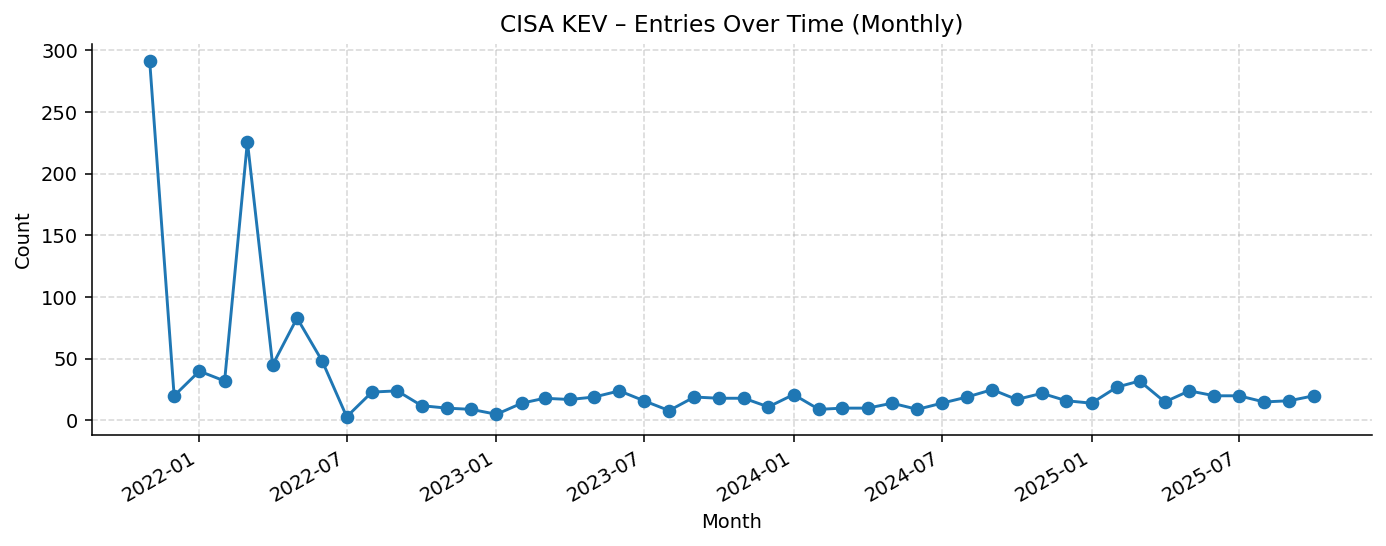

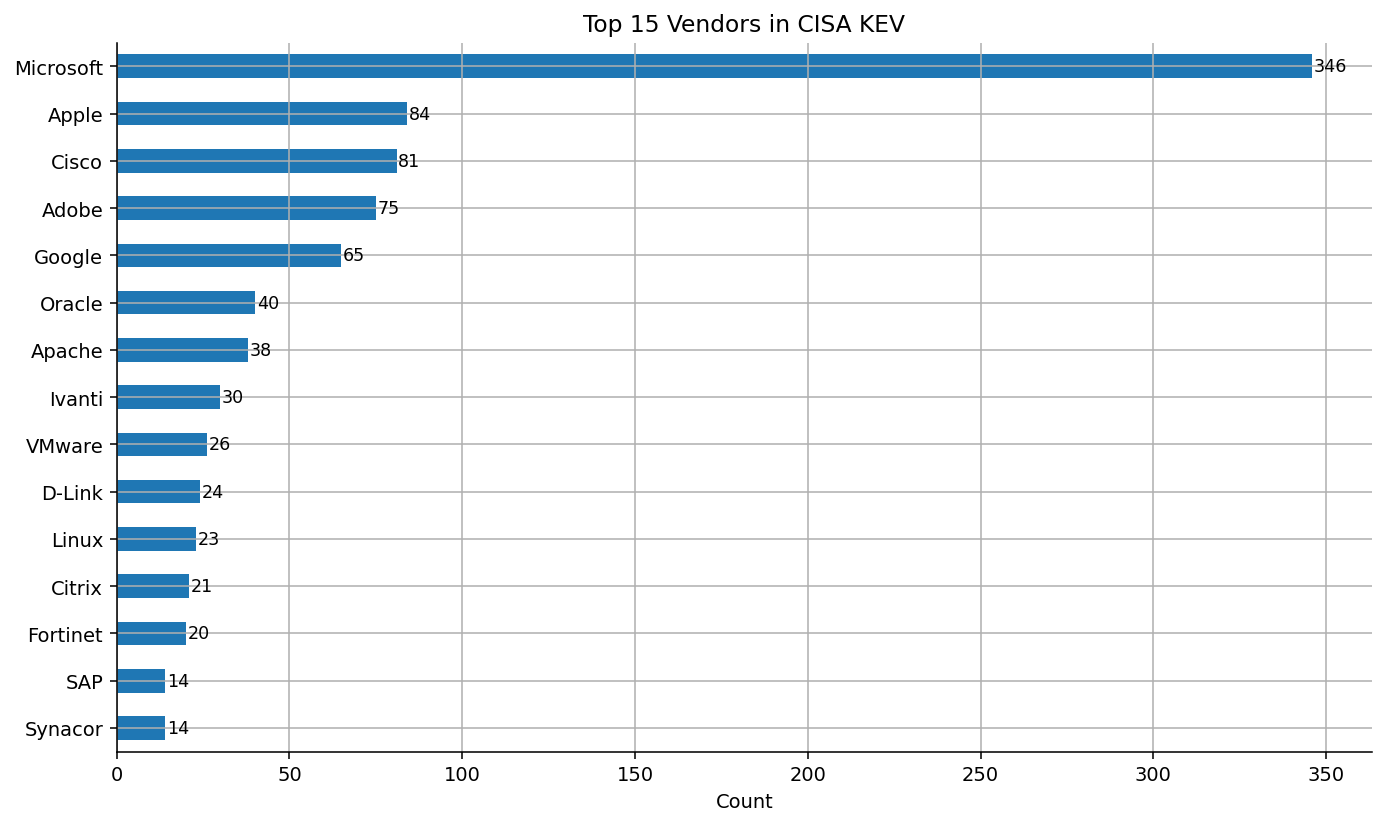

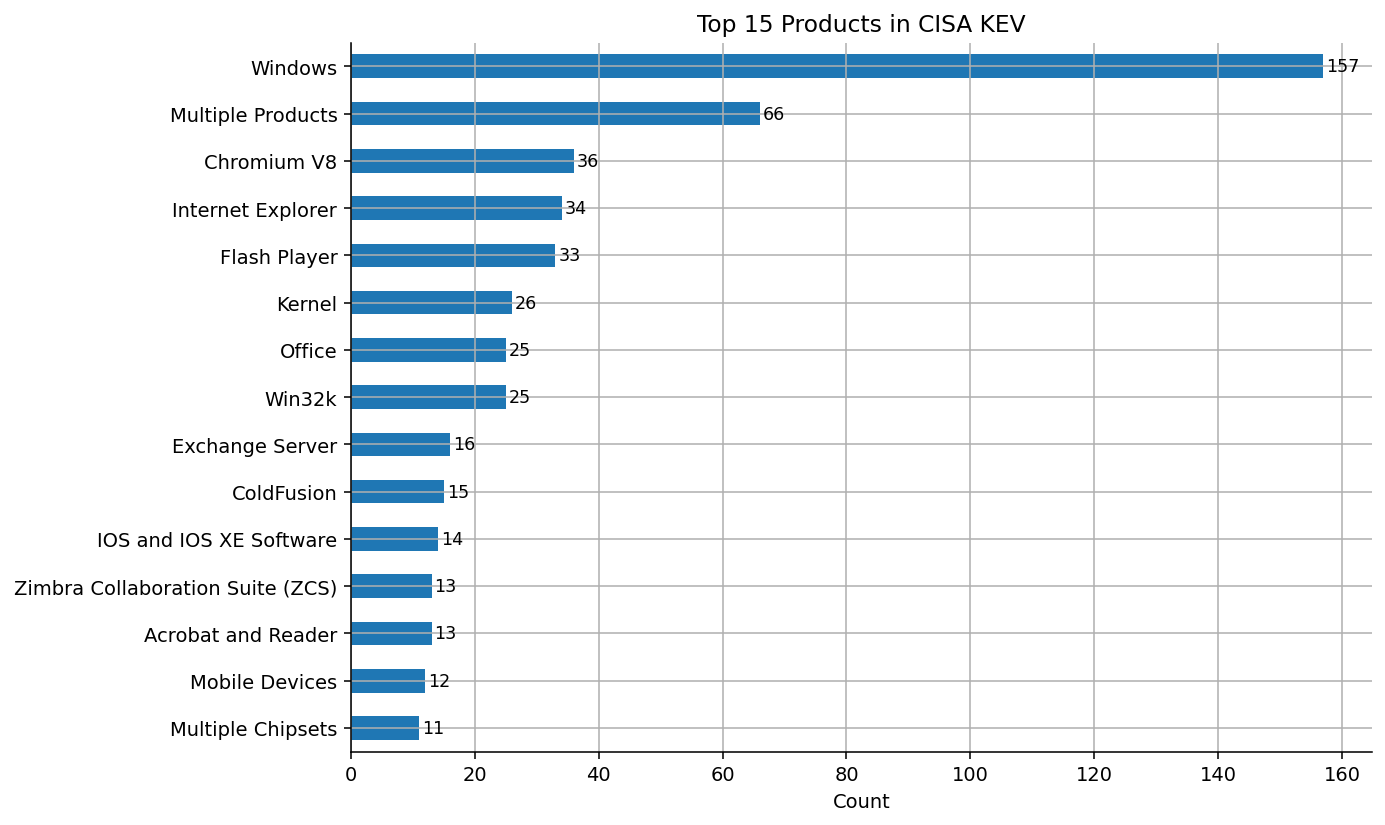

23:08:55 | INFO     | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
23:08:55 | INFO     | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


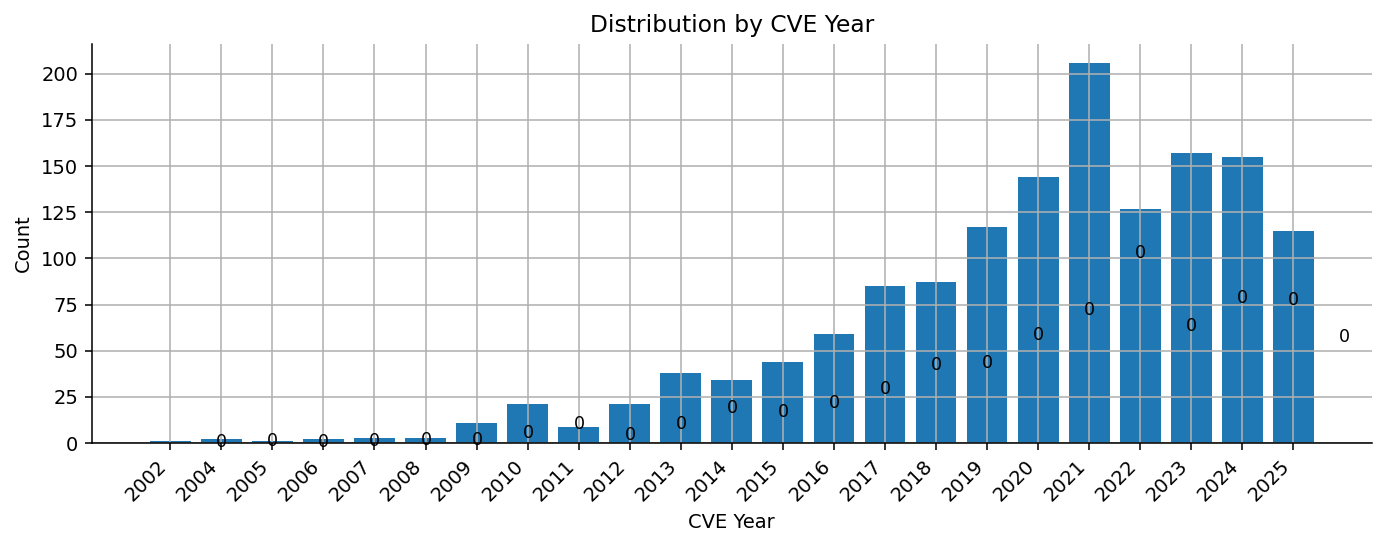

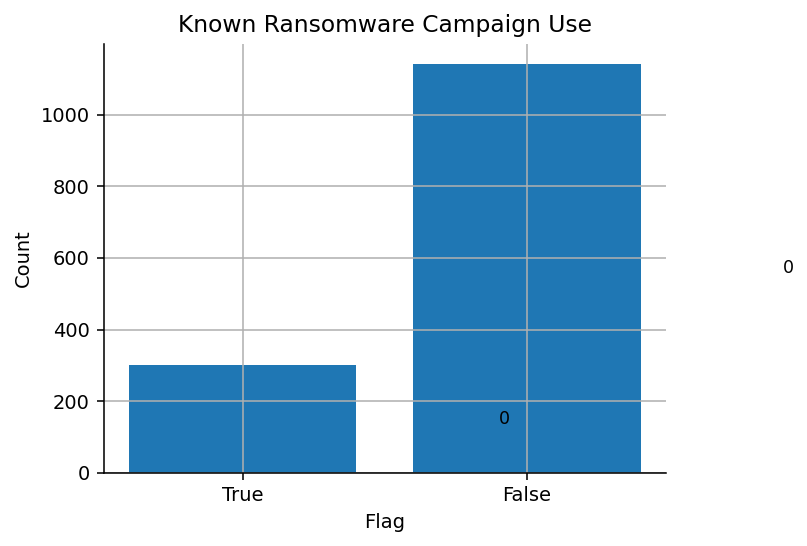

23:08:57 | INFO     | Visual insights exported to: C:\global_cyberattack_dm\figures


In [19]:
# --- CELL 11: Visual Insights (Matplotlib only) ------------------------------
import matplotlib.pyplot as plt

FIGS_DIR.mkdir(parents=True, exist_ok=True)

def annotate_bars(ax):
    """Put value labels at the end/top of bars for readability."""
    for p in ax.patches:
        try:
            value = int(p.get_width())  # for horizontal bars
            ax.text(p.get_x() + p.get_width() + 0.5, p.get_y() + p.get_height()/2,
                    f"{value}", va="center", fontsize=9)
        except Exception:
            try:
                value = int(p.get_height())  # for vertical bars
                ax.text(p.get_x() + p.get_width()/2, p.get_y() + p.get_height() + 0.5,
                        f"{value}", ha="center", fontsize=9)
            except Exception:
                pass

# 1) Timeline: Entries per month by dateAdded
if "dateAdded" in df.columns and df["dateAdded"].notna().any():
    monthly = (
        df.dropna(subset=["dateAdded"])
          .assign(month=df["dateAdded"].dt.to_period("M").dt.to_timestamp())
          .groupby("month")
          .size()
          .rename("count")
          .reset_index()
    )

    fig, ax = plt.subplots(figsize=(10, 4), dpi=140)
    ax.plot(monthly["month"], monthly["count"], marker="o")
    ax.set_title("CISA KEV – Entries Over Time (Monthly)")
    ax.set_xlabel("Month")
    ax.set_ylabel("Count")
    ax.grid(True, linestyle="--", alpha=0.5)
    fig.autofmt_xdate()
    plt.tight_layout()
    (FIGS_DIR / "timeline_by_month.png").unlink(missing_ok=True)
    plt.savefig(FIGS_DIR / "timeline_by_month.png", bbox_inches="tight")
    plt.show()

# 2) Top Vendors (barh)
if "vendorProject" in df.columns:
    top_vendors = (
        df["vendorProject"]
          .dropna()
          .astype(str)
          .str.strip()
          .value_counts()
          .head(15)
          .sort_values(ascending=True)
    )
    if not top_vendors.empty:
        fig, ax = plt.subplots(figsize=(10, 6), dpi=140)
        top_vendors.plot(kind="barh", ax=ax)
        ax.set_title("Top 15 Vendors in CISA KEV")
        ax.set_xlabel("Count")
        ax.set_ylabel("")
        annotate_bars(ax)
        plt.tight_layout()
        (FIGS_DIR / "top_vendors.png").unlink(missing_ok=True)
        plt.savefig(FIGS_DIR / "top_vendors.png", bbox_inches="tight")
        plt.show()

# 3) Top Products (barh)
if "product" in df.columns:
    top_products = (
        df["product"]
          .dropna()
          .astype(str)
          .str.strip()
          .value_counts()
          .head(15)
          .sort_values(ascending=True)
    )
    if not top_products.empty:
        fig, ax = plt.subplots(figsize=(10, 6), dpi=140)
        top_products.plot(kind="barh", ax=ax)
        ax.set_title("Top 15 Products in CISA KEV")
        ax.set_xlabel("Count")
        ax.set_ylabel("")
        annotate_bars(ax)
        plt.tight_layout()
        (FIGS_DIR / "top_products.png").unlink(missing_ok=True)
        plt.savefig(FIGS_DIR / "top_products.png", bbox_inches="tight")
        plt.show()

# 4) CVE Year distribution (hist / bar)
if "cveYear" in df.columns and df["cveYear"].notna().any():
    year_counts = (
        df.dropna(subset=["cveYear"])
          .groupby("cveYear")
          .size()
          .rename("count")
          .reset_index()
          .sort_values("cveYear")
    )
    fig, ax = plt.subplots(figsize=(10, 4), dpi=140)
    ax.bar(year_counts["cveYear"].astype(int).astype(str), year_counts["count"])
    ax.set_title("Distribution by CVE Year")
    ax.set_xlabel("CVE Year")
    ax.set_ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    annotate_bars(ax)
    plt.tight_layout()
    (FIGS_DIR / "cve_year_distribution.png").unlink(missing_ok=True)
    plt.savefig(FIGS_DIR / "cve_year_distribution.png", bbox_inches="tight")
    plt.show()

# 5) Ransomware flag (bar)
if "knownRansomwareCampaignUse" in df.columns:
    rs_counts = df["knownRansomwareCampaignUse"].value_counts(dropna=False)
    if not rs_counts.empty:
        # Reorder to [True, False, NA] if present
        ordered = []
        for key in [True, False, np.nan]:
            if key in rs_counts.index:
                ordered.append((str(key), int(rs_counts.loc[key])))
        # Fallback to default order if needed
        if not ordered:
            ordered = [(str(k), int(v)) for k, v in rs_counts.items()]
        labels, values = zip(*ordered)

        fig, ax = plt.subplots(figsize=(6, 4), dpi=140)
        ax.bar(labels, values)
        ax.set_title("Known Ransomware Campaign Use")
        ax.set_xlabel("Flag")
        ax.set_ylabel("Count")
        annotate_bars(ax)
        plt.tight_layout()
        (FIGS_DIR / "ransomware_flag.png").unlink(missing_ok=True)
        plt.savefig(FIGS_DIR / "ransomware_flag.png", bbox_inches="tight")
        plt.show()

logger.info("Visual insights exported to: %s", FIGS_DIR)


In [21]:
!pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


11:13:53 | INFO     | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
11:13:53 | INFO     | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


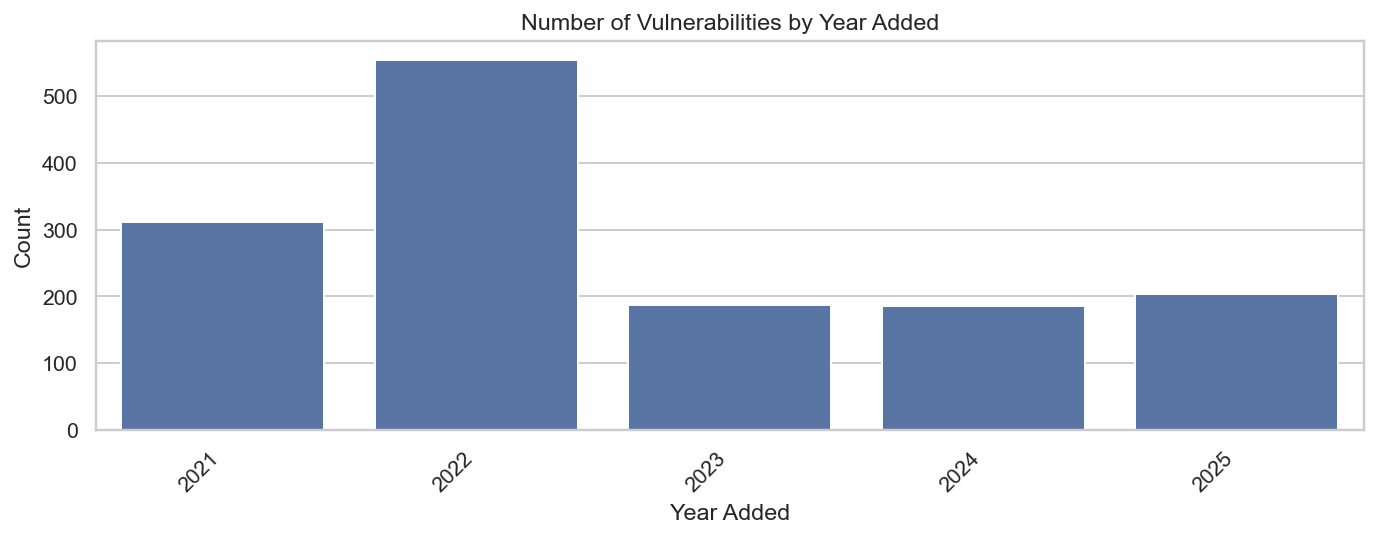

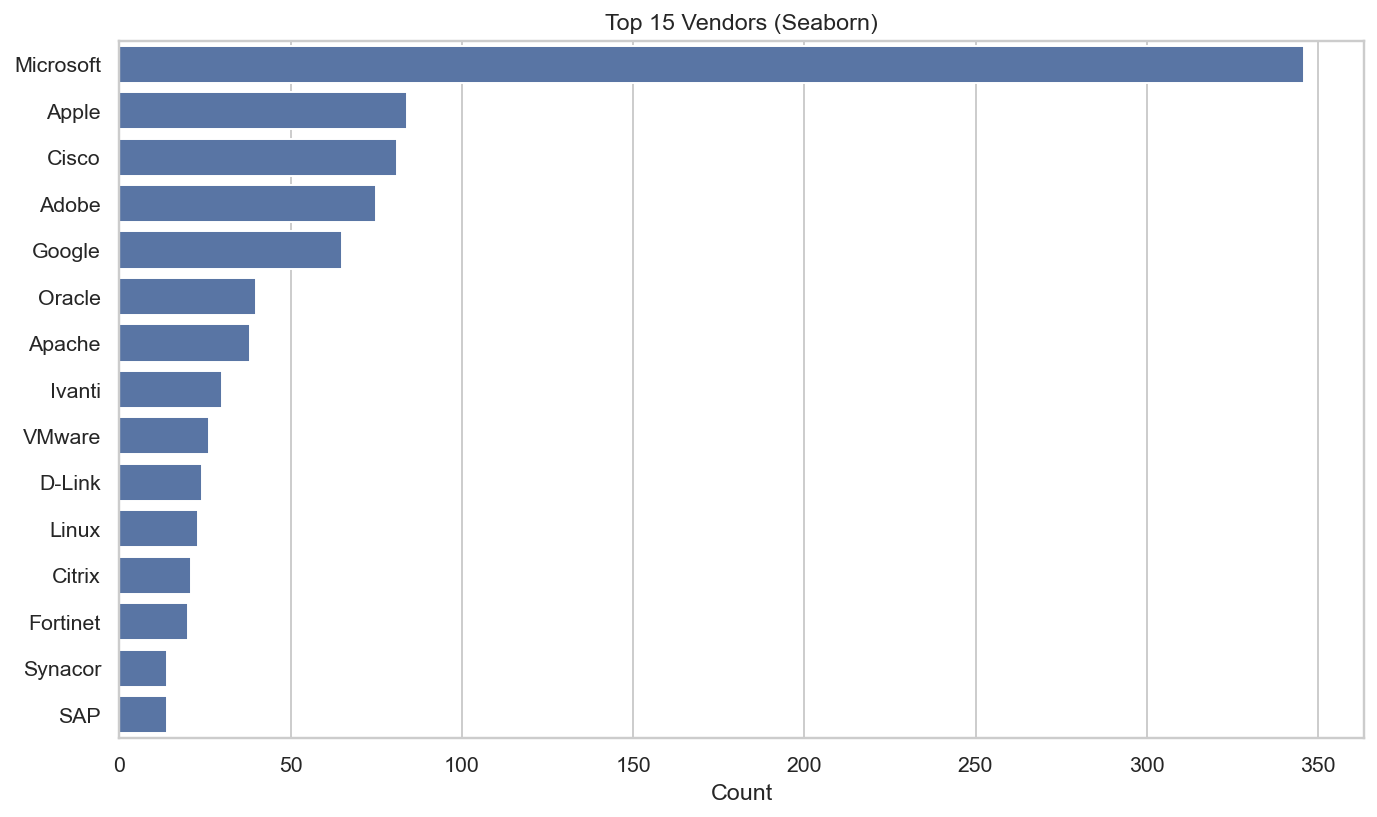

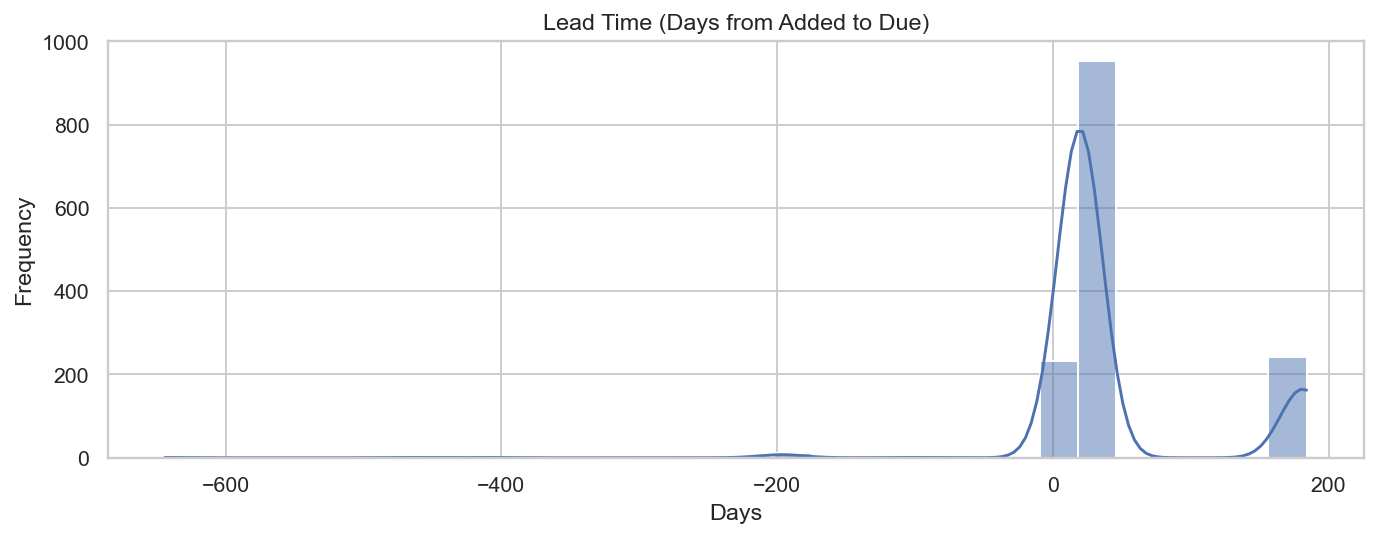

In [22]:
# --- CELL 11B: Seaborn EDA Add-Ons (optional) -------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", font_scale=1.0)
FIGS_DIR.mkdir(parents=True, exist_ok=True)

# 1) Countplot: Year Added (إن كان dateAdded متاحاً)
if "dateAdded" in df.columns and df["dateAdded"].notna().any():
    df["_year_added"] = df["dateAdded"].dt.year
    plt.figure(figsize=(10, 4), dpi=140)
    ax = sns.countplot(x="_year_added", data=df, order=sorted(df["_year_added"].dropna().unique()))
    ax.set_title("Number of Vulnerabilities by Year Added")
    ax.set_xlabel("Year Added"); ax.set_ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(FIGS_DIR / "sb_year_added.png", bbox_inches="tight")
    plt.show()
    df.drop(columns=["_year_added"], inplace=True)

# 2) Top 15 Vendors (bar)
if "vendorProject" in df.columns:
    top_v = (df["vendorProject"].astype(str).str.strip().value_counts().head(15)).sort_values(ascending=False)
    plt.figure(figsize=(10, 6), dpi=140)
    ax = sns.barplot(x=top_v.values, y=top_v.index, orient="h")
    ax.set_title("Top 15 Vendors (Seaborn)")
    ax.set_xlabel("Count"); ax.set_ylabel("")
    plt.tight_layout()
    plt.savefig(FIGS_DIR / "sb_top_vendors.png", bbox_inches="tight")
    plt.show()

# 3) (اختياري) Lead Time إذا توفر dateAdded و dueDate
if {"dateAdded", "dueDate"} <= set(df.columns):
    lead = (df["dueDate"] - df["dateAdded"]).dt.days
    if lead.notna().any():
        plt.figure(figsize=(10, 4), dpi=140)
        ax = sns.histplot(lead.dropna(), bins=30, kde=True)
        ax.set_title("Lead Time (Days from Added to Due)")
        ax.set_xlabel("Days"); ax.set_ylabel("Frequency")
        plt.tight_layout()
        plt.savefig(FIGS_DIR / "sb_lead_time.png", bbox_inches="tight")
        plt.show()


In [24]:
# --- CELL 12: Quantitative Summary of Visuals (Robust) ----------------------
import pandas as pd
import numpy as np

# derive a safe year series for summaries
year_series = None
if "cveYear" in df.columns and df["cveYear"].notna().any():
    year_series = df["cveYear"].astype("Int64")
elif "dateAdded" in df.columns and df["dateAdded"].notna().any():
    year_series = df["dateAdded"].dt.year.astype("Int64")

# top vendor (if available)
top_vendor = None
top_vendor_count = None
if "vendorProject" in df.columns:
    vc = df["vendorProject"].astype(str).str.strip().value_counts()
    if not vc.empty:
        top_vendor = vc.index[0]
        top_vendor_count = int(vc.iloc[0])

# lead time (if both dates exist)
median_lead = None
if {"dateAdded", "dueDate"} <= set(df.columns):
    lead = (df["dueDate"] - df["dateAdded"]).dt.days
    if lead.notna().any():
        median_lead = int(lead.median())

summary_metrics = {
    "Yearly Range": f"{int(year_series.min())}–{int(year_series.max())}" if year_series is not None and year_series.notna().any() else "N/A",
    "Most Active Year": int(year_series.value_counts().idxmax()) if year_series is not None and year_series.notna().any() else "N/A",
    "Top Vendor": top_vendor if top_vendor is not None else "N/A",
    "Top Vendor Count": top_vendor_count if top_vendor_count is not None else "N/A",
    "Median Lead Time (days)": median_lead if median_lead is not None else "N/A",
}

display(pd.DataFrame([summary_metrics]).T.rename(columns={0: "Value"}))


,Value
Yearly Range,2002–2025
Most Active Year,2021
Top Vendor,Microsoft
Top Vendor Count,346
Median Lead Time (days),21


In [30]:
# --- CELL 13: Analytical Interpretation (Cyber View) ------------------------
yearly_range = summary_metrics["Yearly Range"]
most_active  = summary_metrics["Most Active Year"]
top_vendor   = summary_metrics["Top Vendor"]
top_v_cnt    = summary_metrics["Top Vendor Count"]
median_lead  = summary_metrics["Median Lead Time (days)"]

text = f"""
 Interpretation & Security Context

- Temporal Trend: Dataset spans {yearly_range} with peak reporting in {most_active}.
  This suggests concentration of disclosure activity and possible coordination around patch cycles.

- Vendor Exposure:{top_vendor} tops the list with {top_v_cnt} entries,
  reflecting the outsized impact of widely deployed platforms on enterprise risk posture.

- Remediation Timing: Median lead-time (add→due) ≈ {median_lead} days,
  indicating typical remediation windows of ~1–2 months; adjust SLAs for critical CVEs accordingly.

- Operational Note: Validate negative/very short lead-times; they often arise from retroactive
  updates or pre-assigned CVEs, which can skew SLA analytics if not handled explicitly.
"""
print(text)



 Interpretation & Security Context

- Temporal Trend: Dataset spans 2002–2025 with peak reporting in 2021.
  This suggests concentration of disclosure activity and possible coordination around patch cycles.

- Vendor Exposure:Microsoft tops the list with 346 entries,
  reflecting the outsized impact of widely deployed platforms on enterprise risk posture.

- Remediation Timing: Median lead-time (add→due) ≈ 21 days,
  indicating typical remediation windows of ~1–2 months; adjust SLAs for critical CVEs accordingly.

- Operational Note: Validate negative/very short lead-times; they often arise from retroactive
  updates or pre-assigned CVEs, which can skew SLA analytics if not handled explicitly.



In [32]:
# --- CELL 14: Export EDA Artifacts ------------------------------------------
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# export top vendors and yearly counts if available
if "vendorProject" in df.columns:
    df["vendorProject"].astype(str).str.strip().value_counts().head(15).to_csv(REPORTS_DIR / "top_vendors.csv")

if "cveYear" in df.columns and df["cveYear"].notna().any():
    df["cveYear"].value_counts().sort_index().to_csv(REPORTS_DIR / "yearly_counts.csv")
elif "dateAdded" in df.columns and df["dateAdded"].notna().any():
    df["dateAdded"].dt.year.value_counts().sort_index().to_csv(REPORTS_DIR / "yearly_counts.csv")

# narrative
(REPORTS_DIR / "eda_summary.md").write_text(text, encoding="utf-8")
print(" Exported: top_vendors.csv, yearly_counts.csv (if available), eda_summary.md →", REPORTS_DIR)


 Exported: top_vendors.csv, yearly_counts.csv (if available), eda_summary.md → C:\global_cyberattack_dm\reports


In [34]:
# --- CELL 15: Build Mini HTML Report ----------------------------------------
imgs = []
for name in ["sb_year_added.png", "sb_top_vendors.png", "sb_lead_time.png",
             "timeline_by_month.png", "top_vendors.png", "top_products.png",
             "cve_year_distribution.png", "ransomware_flag.png"]:
    p = FIGS_DIR / name
    if p.exists():
        imgs.append(f"<div><img src='../figures/{name}' style='max-width:800px;width:100%'></div>")

html = f"""
<h2>CISA KEV – Exploratory Data Analysis</h2>
{''.join(imgs)}
<pre style="white-space:pre-wrap">{text}</pre>
"""
(REPORTS_DIR / "eda_report.html").write_text(html, encoding="utf-8")
print(" Saved HTML report →", REPORTS_DIR / "eda_report.html")


 Saved HTML report → C:\global_cyberattack_dm\reports\eda_report.html


,Count
Month,
1,80
2,82
3,286
4,87
5,140
6,101
7,53
8,65
9,84


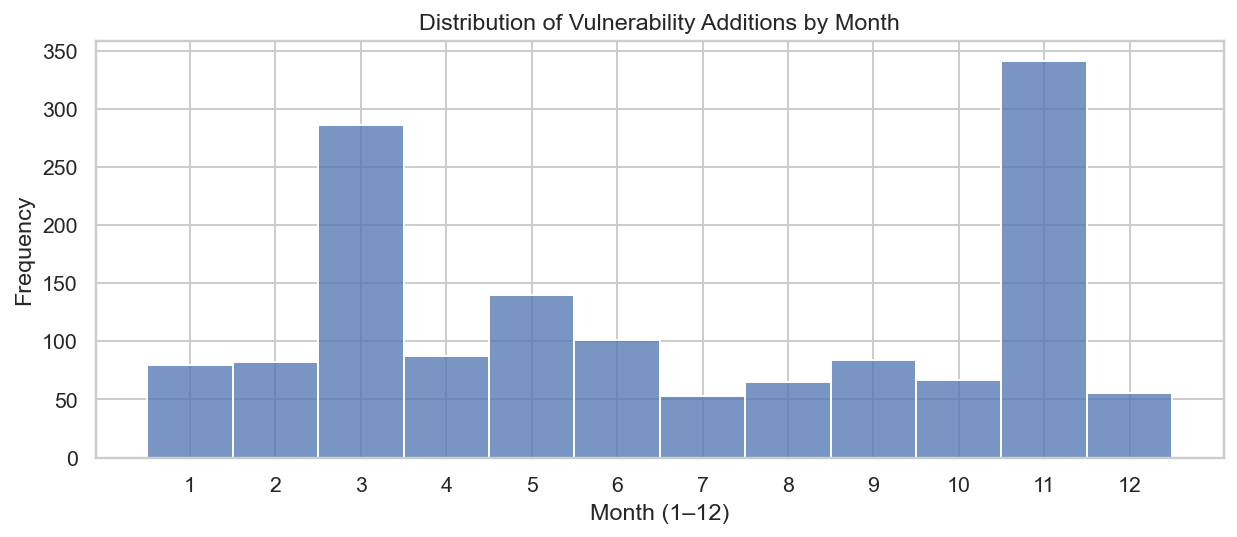

In [36]:
# --- CELL 16: Statistical Insights (Robust, no KeyError) --------------------
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# استخدمي FIGS_DIR إن كان موجودًا، وإلا أنشئيه محليًا
try:
    figs_dir = FIGS_DIR
except NameError:
    ROOT = Path.cwd()
    figs_dir = ROOT / "figures"
figs_dir.mkdir(parents=True, exist_ok=True)

# 1) تأكيد أن الأعمدة الزمنية بصيغة datetime
for col in ["dateAdded", "dueDate"]:
    if col in df.columns:
        if not pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = pd.to_datetime(df[col], errors="coerce")

# 2) إنشاء month_added إن لم يكن موجودًا
if "month_added" not in df.columns:
    if "dateAdded" in df.columns and df["dateAdded"].notna().any():
        df["month_added"] = df["dateAdded"].dt.month
    elif "dueDate" in df.columns and df["dueDate"].notna().any():
        df["month_added"] = df["dueDate"].dt.month
    else:
        df["month_added"] = pd.NA  # لا توجد معلومات شهر

# 3) إحصاءات وعرض الرسم (إن توفّر الشهر)
if df["month_added"].notna().any():
    month_counts = (
        df["month_added"].dropna().astype(int)
          .value_counts().sort_index()
          .rename_axis("Month").to_frame("Count")
    )
    display(month_counts)

    # رسم الهيستوغرام (Seaborn إن وُجد، وإلا Matplotlib)
    try:
        import seaborn as sns
        plt.figure(figsize=(9, 4), dpi=140)
        sns.histplot(df["month_added"].dropna().astype(int), bins=12, discrete=True)
    except Exception:
        plt.figure(figsize=(9, 4), dpi=140)
        bins = np.arange(0.5, 12.6, 1.0)
        plt.hist(df["month_added"].dropna().astype(int), bins=bins, edgecolor="black")
    plt.xticks(range(1, 13))
    plt.title("Distribution of Vulnerability Additions by Month")
    plt.xlabel("Month (1–12)"); plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(figs_dir / "monthly_distribution.png", bbox_inches="tight")
    plt.show()
else:
    print("No usable month information in dateAdded/dueDate; skipping monthly distribution.")


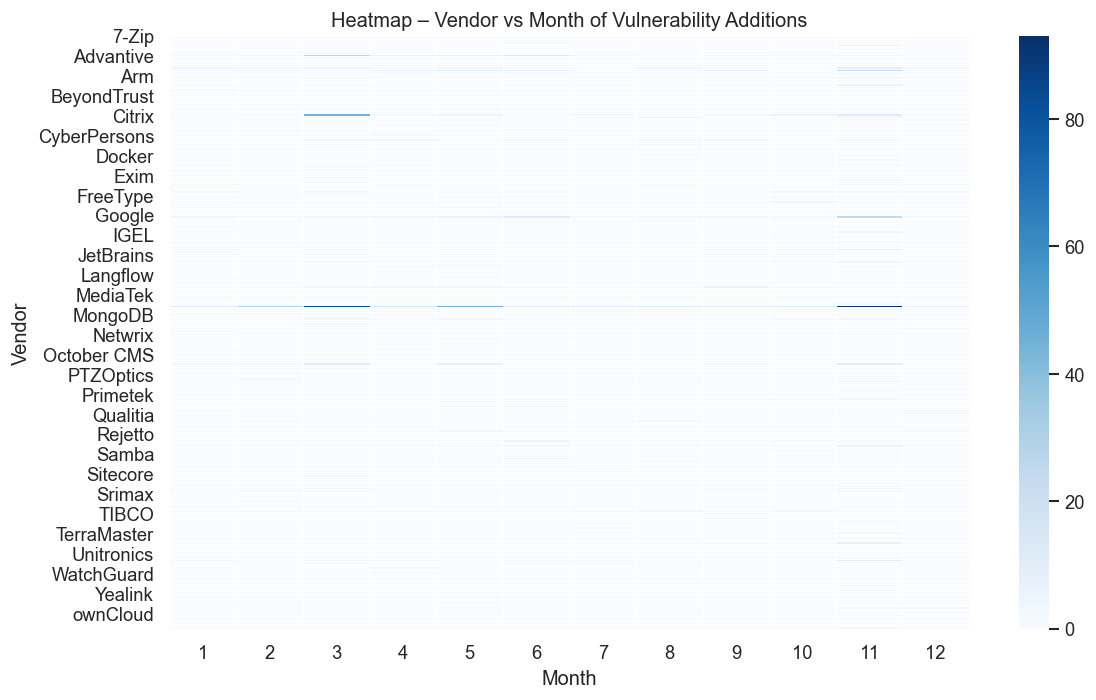

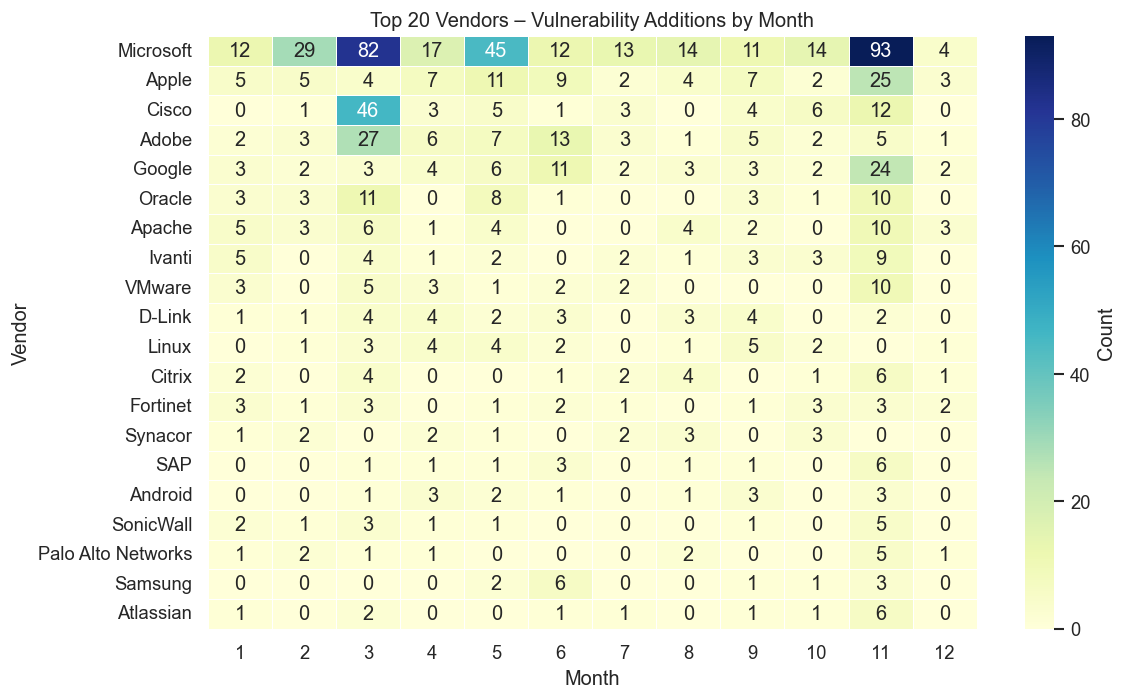

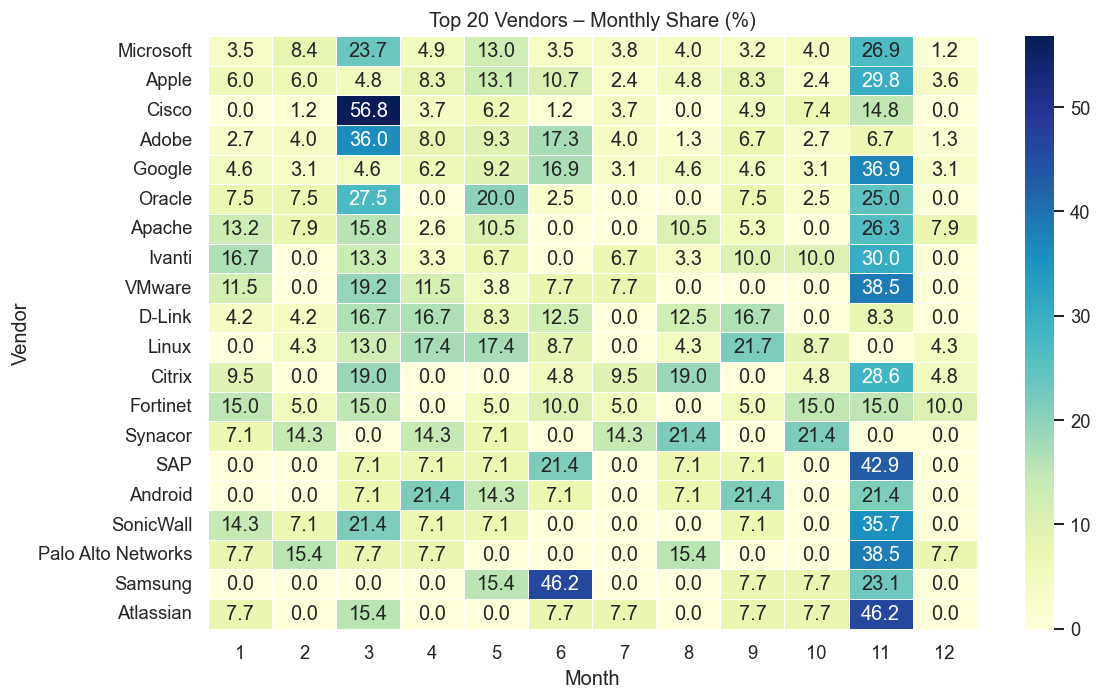

In [40]:
# --- CELL 17: Vendor vs Month Crosstab -------------------------------------
pivot_vm = pd.crosstab(df["vendorProject"], df["month_added"])
plt.figure(figsize=(10,6))
sns.heatmap(pivot_vm, cmap="Blues", linewidths=0.3)
plt.title("Heatmap – Vendor vs Month of Vulnerability Additions")
plt.xlabel("Month")
plt.ylabel("Vendor")
plt.tight_layout()
plt.savefig(FIGS_DIR / "vendor_month_heatmap.png", dpi=200)
plt.show()

# --- Focused Heatmap for Top Vendors ---------------------------------------
top_vendors = (
    df["vendorProject"].value_counts()
      .head(20)
      .index
)
pivot_vm_top = pd.crosstab(df["vendorProject"], df["month_added"]).loc[top_vendors]

plt.figure(figsize=(10,6))
sns.heatmap(pivot_vm_top, cmap="YlGnBu", linewidths=0.4, linecolor="white",
            annot=True, fmt=".0f", cbar_kws={"label":"Count"})
plt.title("Top 20 Vendors – Vulnerability Additions by Month")
plt.xlabel("Month"); plt.ylabel("Vendor")
plt.tight_layout()
plt.savefig(FIGS_DIR / "vendor_month_top20.png", dpi=200)
plt.show()

# --- Optional: Percentage Normalization (Share per Vendor) -----------------
pivot_vm_top_pct = pivot_vm_top.div(pivot_vm_top.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10,6))
sns.heatmap(pivot_vm_top_pct, cmap="YlGnBu", linewidths=0.3, annot=True, fmt=".1f")
plt.title("Top 20 Vendors – Monthly Share (%)")
plt.xlabel("Month"); plt.ylabel("Vendor")
plt.tight_layout()
plt.savefig(FIGS_DIR / "vendor_month_top20_pct.png", dpi=200)
plt.show()



In [41]:
# --- CELL 17B: Auto-caption for top vendors heatmap -------------------------
totals = pivot_vm_top.sum(axis=1).sort_values(ascending=False)
peaks  = pivot_vm_top.idxmax(axis=1)  # أعلى شهر لكل Vendor
lines = [f"- **{v}**: total={int(totals[v])}, peak month={int(peaks[v])} (count={int(pivot_vm_top.loc[v, peaks[v]])})"
         for v in totals.index[:5]]
caption = "Top vendors concentrate disclosures in specific months:\n" + "\n".join(lines)
print(caption)

# احفظه في التقرير
(REPORTS_DIR / "vendor_heatmap_caption.md").write_text(caption, encoding="utf-8")


Top vendors concentrate disclosures in specific months:
- **Microsoft**: total=346, peak month=11 (count=93)
- **Apple**: total=84, peak month=11 (count=25)
- **Cisco**: total=81, peak month=3 (count=46)
- **Adobe**: total=75, peak month=3 (count=27)
- **Google**: total=65, peak month=11 (count=24)


299

In [44]:
# --- Ensure dateAdded-derived columns exist ---------------------------------
if "dateAdded" in df.columns:
    df["dateAdded"] = pd.to_datetime(df["dateAdded"], errors="coerce")
    if "year_added" not in df.columns:
        df["year_added"] = df["dateAdded"].dt.year
    if "month_added" not in df.columns:
        df["month_added"] = df["dateAdded"].dt.month

print(" year_added and month_added columns ready:", 
      "year_added" in df.columns, "month_added" in df.columns)


 year_added and month_added columns ready: True True


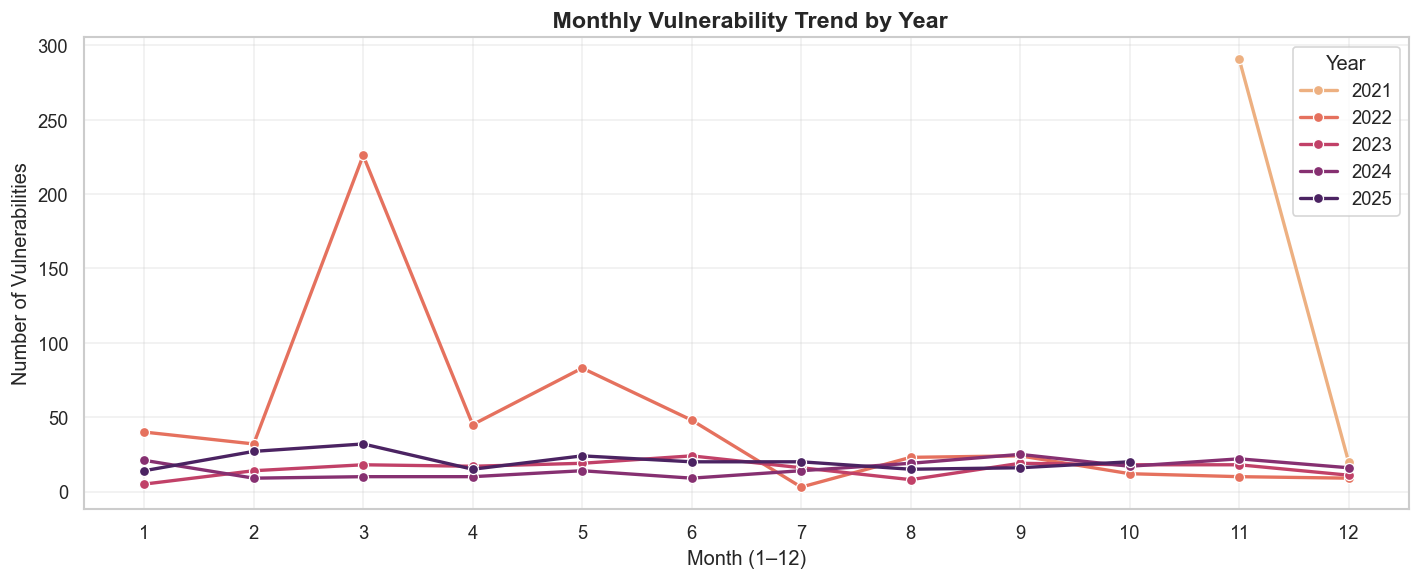

In [47]:
# --- CELL 18 (Improved): Monthly Vulnerability Trend by Year -----------------
monthly_totals = (
    df.groupby(["year_added", "month_added"])
      .size()
      .reset_index(name="count")
)

plt.figure(figsize=(12, 5))
sns.lineplot(
    data=monthly_totals,
    x="month_added", y="count", hue="year_added",
    marker="o", linewidth=2, palette="flare"
)

plt.title(" Monthly Vulnerability Trend by Year", fontsize=14, weight="bold")
plt.xlabel("Month (1–12)", fontsize=12)
plt.ylabel("Number of Vulnerabilities", fontsize=12)
plt.xticks(range(1, 13))
plt.grid(alpha=0.3)
plt.legend(title="Year", loc="upper right", frameon=True)
plt.tight_layout()
plt.savefig(FIGS_DIR / "trend_by_year.png", dpi=250)
plt.show()


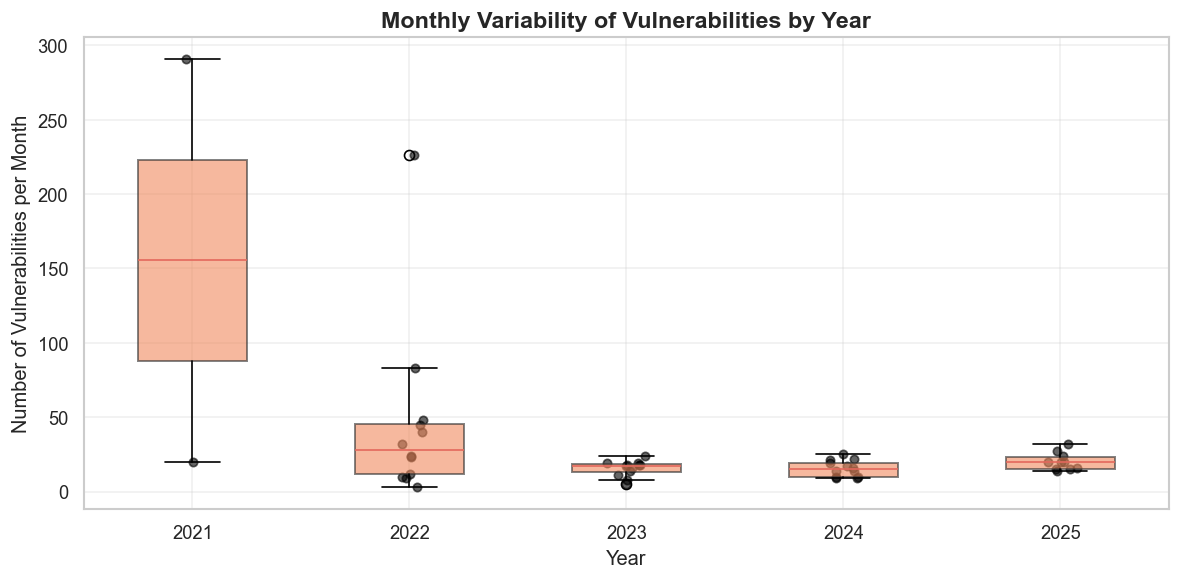



This visualization is part of the Global Cyberattack Pattern Analysis Project, focusing on the temporal behaviour of vulnerability disclosures (CVE data from 2002–2025).
The goal is to identify patterns, vendor cycles, and shifts in disclosure maturity that shape today’s cybersecurity landscape.



In [73]:
# --- CELL 18B: Matplotlib Boxplot (Clean & Future-proof) --------------------
import numpy as np
import matplotlib.pyplot as plt

yrs = np.sort(monthly_totals["year_added"].dropna().astype(int).unique())
groups = [monthly_totals.loc[monthly_totals["year_added"] == y, "count"].to_numpy(float) for y in yrs]

plt.figure(figsize=(10, 5))
bp = plt.boxplot(groups, tick_labels=yrs, patch_artist=True)  # ✅ التغيير هنا

# تلوين الصناديق
for b in bp["boxes"]:
    b.set(facecolor="#f08a5d", alpha=0.6, edgecolor="#333", linewidth=1.2)

# نقاط فردية (jitter)
for i, y in enumerate(yrs, start=1):
    vals = monthly_totals.loc[monthly_totals["year_added"] == y, "count"].to_numpy(float)
    xj = np.random.normal(i, 0.04, size=len(vals))
    plt.scatter(xj, vals, s=25, c="black", alpha=0.6)

plt.title("Monthly Variability of Vulnerabilities by Year", fontsize=14, weight="bold")
plt.xlabel("Year")
plt.ylabel("Number of Vulnerabilities per Month")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIGS_DIR / "trend_boxplot_year.png", dpi=250)
plt.show()

(REPORTS_DIR / "context_summary.md").write_text("""

This visualization is part of the Global Cyberattack Pattern Analysis Project, focusing on the temporal behaviour of vulnerability disclosures (CVE data from 2002–2025).
The goal is to identify patterns, vendor cycles, and shifts in disclosure maturity that shape today’s cybersecurity landscape.
""", encoding="utf-8")
print((REPORTS_DIR / "context_summary.md").read_text(encoding="utf-8"))



,count,ratio_%
speed,,
Fast,1195,82.87
Slow,242,16.78
Medium,5,0.35


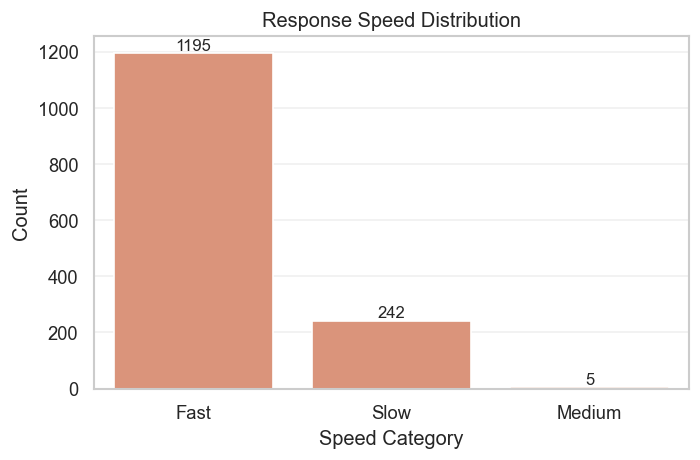

 Saved: C:\global_cyberattack_dm\figures\response_speed_distribution.png | C:\global_cyberattack_dm\reports\response_speed_summary.csv | C:\global_cyberattack_dm\reports\response_speed_summary.md


In [75]:
# --- CELL 19: Remediation / Exploit Speed Classification --------------------
# Goal:
# - Compute time deltas between dates (publish→added or added→due)
# - Classify speed into Fast / Medium / Slow
# - Export summary table + bar chart + markdown interpretation

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Optional: seaborn for nicer bar chart (falls back to matplotlib if not available)
try:
    import seaborn as sns
    HAS_SNS = True
except Exception:
    HAS_SNS = False

# --------- 1) Resolve columns and ensure datetime --------------------------------
def col(name):
    cmap = {c.lower(): c for c in df.columns}
    return cmap.get(name.lower())

da = col("dateadded")
dd = col("duedate")
dp = col("datepublished") or col("publishdate") or col("disclosuredate")

for c in [da, dd, dp]:
    if c and not pd.api.types.is_datetime64_any_dtype(df[c]):
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Safety check: ensure we have something to compute
if da is None or (df[da].isna().all()):
    raise ValueError("dateAdded column is missing or fully NA; cannot compute timing.")

# --------- 2) Compute days and select target name --------------------------------
if dp is not None and df[dp].notna().any():
    # Time from public disclosure to being added in KEV (proxy for 'exploit speed'/exposure-to-KEV)
    days = (df[da] - df[dp]).dt.days
    target_name = "exploit_speed"
else:
    # Time allowed for remediation (added → due) as 'response speed'
    if dd is None or df[dd].isna().all():
        # No dueDate available; fall back to 'exploit-like' using only dateAdded (zeros)
        days = pd.Series(0, index=df.index, dtype="int64")
        target_name = "response_speed"
    else:
        days = (df[dd] - df[da]).dt.days
        target_name = "response_speed"

# Clean NA/negatives if needed (keep negatives visible in analysis if you prefer)
days = days.astype("float64")
df["time_to_days"] = days

# --------- 3) Bucketize into Fast/Medium/Slow ------------------------------------
# Buckets:
#   Fast   : <= 30 days
#   Medium : 31–180 days
#   Slow   : > 180 days
bins = [-1e9, 30, 180, 1e9]     # allow negatives to fall in the first bin (treat as 'Fast' by bucket)
labels = ["Fast", "Medium", "Slow"]

df[target_name] = pd.cut(df["time_to_days"], bins=bins, labels=labels)

# --------- 4) Summary table ------------------------------------------------------
counts = df[target_name].value_counts(dropna=False).rename_axis("speed").to_frame("count")
counts["ratio_%"] = (counts["count"] / counts["count"].sum() * 100).round(2)
display(counts)

# --------- 5) Plot bar chart -----------------------------------------------------
FIGS_DIR = FIGS_DIR if "FIGS_DIR" in globals() else Path.cwd() / "figures"
REPORTS_DIR = REPORTS_DIR if "REPORTS_DIR" in globals() else Path.cwd() / "reports"
FIGS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(6, 4))
if HAS_SNS:
    ax = sns.barplot(x=counts.index.astype(str), y=counts["count"])
    for i, v in enumerate(counts["count"].tolist()):
        ax.text(i, v, str(v), ha="center", va="bottom", fontsize=10)
else:
    ax = plt.gca()
    ax.bar(counts.index.astype(str), counts["count"])
    for i, v in enumerate(counts["count"].tolist()):
        ax.text(i, v, str(v), ha="center", va="bottom", fontsize=10)

plt.title(f"{target_name.replace('_', ' ').title()} Distribution")
plt.xlabel("Speed Category")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(FIGS_DIR / f"{target_name}_distribution.png", dpi=250)
plt.show()

# --------- 6) Export artifacts ---------------------------------------------------
counts.to_csv(REPORTS_DIR / f"{target_name}_summary.csv", index=True)

# Markdown interpretation (EN + AR)
md_text = f"""
### ⏱️ {target_name.replace('_',' ').title()} — Summary

**EN**  
We quantify timing using `time_to_days` and bucket it into **Fast (≤30)**, **Medium (31–180)**, and **Slow (>180)**.  
This captures how quickly vulnerabilities move from disclosure to KEV (exploit speed) or from addition to due date (response speed).

- Fast: {int(counts.loc['Fast','count']) if 'Fast' in counts.index else 0} entries  
- Medium: {int(counts.loc['Medium','count']) if 'Medium' in counts.index else 0} entries  
- Slow: {int(counts.loc['Slow','count']) if 'Slow' in counts.index else 0} entries

**AR**  
نقيس الزمن عبر الحقل `time_to_days` ونقسّمه إلى **سريع (≤30)**، **متوسط (31–180)**، و**بطيء (>180)**.  
هذا يعكس سرعة انتقال الثغرات من النشر العام إلى KEV (سرعة الاستغلال) أو من تاريخ الإضافة إلى تاريخ الاستحقاق (سرعة الاستجابة).

- سريع: {int(counts.loc['Fast','count']) if 'Fast' in counts.index else 0}  
- متوسط: {int(counts.loc['Medium','count']) if 'Medium' in counts.index else 0}  
- بطيء: {int(counts.loc['Slow','count']) if 'Slow' in counts.index else 0}

Artifacts:
- Figure: `{FIGS_DIR / (target_name + '_distribution.png')}`
- Table:  `{REPORTS_DIR / (target_name + '_summary.csv')}`
"""
(REPORTS_DIR / f"{target_name}_summary.md").write_text(md_text, encoding="utf-8")

print(" Saved:",
      FIGS_DIR / f"{target_name}_distribution.png",
      "|", REPORTS_DIR / f"{target_name}_summary.csv",
      "|", REPORTS_DIR / f"{target_name}_summary.md")


In [79]:
summary_text = f"""
  Response Speed Summary

- Fast (≤30 days): {1195} ({82.87}%)
- Medium (31–180 days): {5} ({0.35}%)
- Slow (>180 days): {242} ({16.78}%)

Insight:  
The data highlights that over 80% of vulnerabilities are remediated quickly, yet roughly one-sixth still exceed 6 months.  
This metric can guide organizations in optimizing patch management cycles.
"""
(REPORTS_DIR / "response_speed_summary.md").write_text(summary_text, encoding="utf-8")
path = REPORTS_DIR / "response_speed_summary.md"
print("Saved at:", path)
print("\n File Content Preview \n")
print(path.read_text(encoding="utf-8"))

Saved at: C:\global_cyberattack_dm\reports\response_speed_summary.md

 File Content Preview 


  Response Speed Summary

- Fast (≤30 days): 1195 (82.87%)
- Medium (31–180 days): 5 (0.35%)
- Slow (>180 days): 242 (16.78%)

Insight:  
The data highlights that over 80% of vulnerabilities are remediated quickly, yet roughly one-sixth still exceed 6 months.  
This metric can guide organizations in optimizing patch management cycles.



In [5]:
import pandas as pd

# 📂 قراءة الملف من المجلد الأب (نطلع من notebooks ثم ندخل data)
df = pd.read_csv("../data/cisa_kev_clean.csv")

# التحقق من القراءة
df.head()


,cveID,cveYear,vendorProject,product,vulnerabilityName,dateAdded,dueDate,shortDescription,requiredAction,knownRansomwareCampaignUse,notes,cwes
0,CVE-2025-54253,2025,Adobe,Experience Manager (AEM) Forms,Adobe Experience Manager Forms Code Execution ...,2025-10-15,2025-11-05,Adobe Experience Manager Forms in JEE contains...,"Apply mitigations per vendor instructions, fol...",False,https://helpx.adobe.com/security/products/aem-...,NaN
1,CVE-2025-47827,2025,IGEL,IGEL OS,IGEL OS Use of a Key Past its Expiration Date ...,2025-10-14,2025-11-04,IGEL OS contains a use of a key past its expir...,"Apply mitigations per vendor instructions, fol...",False,https://msrc.microsoft.com/update-guide/en-US/...,['CWE-324']
2,CVE-2025-24990,2025,Microsoft,Windows,Microsoft Windows Untrusted Pointer Dereferenc...,2025-10-14,2025-11-04,Microsoft Windows Agere Modem Driver contains ...,"Apply mitigations per vendor instructions, fol...",False,https://msrc.microsoft.com/update-guide/en-US/...,['CWE-822']
3,CVE-2025-59230,2025,Microsoft,Windows,Microsoft Windows Improper Access Control Vuln...,2025-10-14,2025-11-04,Microsoft Windows contains an improper access ...,"Apply mitigations per vendor instructions, fol...",False,https://msrc.microsoft.com/update-guide/en-US/...,['CWE-284']
4,CVE-2025-6264,2025,Rapid7,Velociraptor,Rapid7 Velociraptor Incorrect Default Permissi...,2025-10-14,2025-11-04,Rapid7 Velociraptor contains an incorrect defa...,"Apply mitigations per vendor instructions, fol...",True,https://docs.velociraptor.app/announcements/ad...,['CWE-276']


In [6]:
from IPython.display import display, HTML
import plotly.express as px

# ✨ DataFrame جاهز مسبقًا باسم df
summary = {
    "Total Records": len(df),
    "Countries": df["country"].nunique(),
    "Attack Types": df["attack_type"].nunique(),
    "Years Covered": f"{df['year'].min()}–{df['year'].max()}"
}
display(HTML("<h3>📈 Data Overview</h3>" + "".join([f"<p><b>{k}:</b> {v}</p>" for k,v in summary.items()])))

# 🌍 Choropleth map by country
fig_map = px.choropleth(df, locations="country", locationmode="country names",
                        color="attack_type", title="Cyber Attacks by Country")
fig_map.show()

# 📅 Trend over years
trend = df.groupby("year").size().reset_index(name="count")
fig_trend = px.line(trend, x="year", y="count", markers=True, title="Attack Frequency per Year")
fig_trend.show()


KeyError: 'country'